In [1]:
library(igraph)
library(tidygraph)
library(magrittr)
library(ggrepel)
library(tidyverse)
library(cowplot)
suppressMessages(library(network))
suppressMessages(library(sna))
library(ggnetwork)
library(scatterpie)

theme_set(theme_cowplot())
results <- '../results/'

fam <- read_delim('~/data/genesis/genesis_2019.fam', delim = ' ', 
                  col_names = FALSE, col_types = 'iciiii')
vegas <- read_tsv(paste0(results,'preprocessing/scored_genes.vegas.txt'), 
                  col_types = 'iciddddddcd') %>%
    rename(p = `Top-0.1-pvalue`) %>%
    select(Gene, p)
ppi <- read_tsv(paste0(results,'preprocessing/hint.ht_complex.hgnc.pseudo.tab2'), col_types = 'cccccccccicc') %>%
    select(`Official Symbol Interactor A`, `Official Symbol Interactor B`) %>%
    graph_from_data_frame(directed = FALSE) %>%
    as_tbl_graph %>%
    left_join(vegas, by = c('name' = 'Gene'))

methods <- c('dmGWAS','heinz','LEAN','SConES GS','SConES GM','SConES GI','SigMod','All')
method_palette <- c('dmGWAS' = '#4daf4a', 'heinz' = '#984ea3',
                    'HotNet2' = '#ff7f00', 'SConES GS' = '#fb6a4a',
                    'SConES GM' = '#cb181d', 'SConES GI' = '#67000d',
                    'SigMod' = '#377eb8', 'All' = 'black')


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘tidygraph’

The following object is masked from ‘package:igraph’:

    groups

The following object is masked from ‘package:stats’:

    filter

Loading required package: ggplot2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  2.1.3     ✔ purrr   0.3.2
✔ tidyr   0.8.3     ✔ dplyr   0.8.3
✔ readr   1.3.1     ✔ stringr 1.4.0
✔ tibble  2.1.3     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::as_data_frame() masks tibble::as_data_frame(), igraph::as_data_frame()
✖ purrr::compose()       masks igraph::compose()
✖ tidyr::crossing()      masks igraph::crossing()
✖ tidyr::extract()       masks magrittr::extract()
✖ dplyr::filter()        masks tidygraph::filter(), stats::filter()
✖ dplyr::groups()    

# Figure 1: Manhattan plots

In [2]:
map <- read_tsv('~/data/genesis/genesis_2019.bim',
                col_names = F, col_types = 'icidcc') %>%
       set_colnames(c('chr', 'snp', 'cm', 'pos', 'x1', 'x2')) %>%
       select(-cm, -x1, -x2)

snp2gene <- read_tsv(paste0(results,'preprocessing/snp2hgnc.tsv'), col_types = 'cc') %>%
    filter(!grepl('LINC', gene))

gwas <- read_tsv(paste0(results,'conventional_gwas/univariate_models.no_covars.tsv'), 
                 col_types = 'icdccccddd') %>%
    rename(chr = CHR, snp = SNP) %>%
    inner_join(map, by = c('chr', 'snp')) %>%
    mutate(selected = ifelse(P < (0.05/n()), 'Yes', 'No')) %>%
    arrange(selected)

don <- gwas %>% 

  # Compute chromosome size
  group_by(chr) %>% 
  summarise(chr_len=max(pos)) %>% 

  # Calculate cumulative position of each chromosome
  mutate(tot=cumsum(chr_len)-chr_len) %>%
  select(-chr_len) %>%

  # Add this info to the initial dataset
  left_join(gwas, ., by='chr') %>%

  # Add a cumulative position of each SNP
  arrange(chr, pos) %>%
  mutate( BPcum=pos+tot) %>%
  left_join(arrange(snp2gene, gene) %>% group_by(snp) %>% summarize(gene = head(gene, 1)), by = 'snp')

bf_threshold <- .05 / (nrow(gwas))
y_lim <- max(-log10(don$P), na.rm = TRUE) + 1
axisdf <- don %>% group_by(chr) %>% summarize(center=( max(BPcum) + min(BPcum) ) / 2 )

options(repr.plot.width=12, repr.plot.height=7.5)
f1a <- ggplot(don, aes(x=BPcum, y=-log10(P))) +

    # Show all points
    geom_point( aes(color=as.factor(chr)), alpha=0.8, size=1.3) +
    geom_point(data = filter(don, selected == 'Yes'), aes(x=BPcum, y=-log10(P)), color = 'black') +
    scale_color_manual(values = rep(c("grey", "skyblue"), 22 )) +

    # Add Bonferroni line
    geom_hline(yintercept = -log10(bf_threshold), color = 'red') +

    # add gene symbols
    geom_text(data = filter(don, selected == 'Yes' & !is.na(gene)) %>% 
                          group_by(gene) %>% 
                          summarise(P = min(P), BPcum = BPcum[which.min(P)]), 
              aes(x=BPcum, y=-log10(P), label = gene), size = 5, nudge_y = .5) +

    # custom X axis:
    scale_x_continuous( label = axisdf$chr, breaks= axisdf$center ) +
    scale_y_continuous(expand = c(0, 0), limits = c(0, y_lim)) +  # remove space between plot area and x axis

    # Custom the theme:
    theme_bw() +
    theme( 
      legend.position="none",
      panel.border = element_blank(),
      axis.title = element_text(size = 15),
      axis.text = element_text(size = 10),
      strip.text.y = element_text(size = .5),
      panel.grid.major.x = element_blank(),
      panel.grid.minor.x = element_blank()
    ) +
    labs(x = 'Chromosome', y = bquote('-log' [10] ~'(P-value)'))

In [3]:
gwas <- read_tsv(paste0(results,'preprocessing/scored_genes.vegas.txt'), 
                        col_types = 'iciddddddcd') %>%
    mutate(selected = ifelse(`Top-0.1-pvalue` < (0.05/n()), 'Yes', 'No')) %>%
    arrange(selected)

don <- gwas %>% 

  # Compute chromosome size
  group_by(Chr) %>% 
  summarise(chr_len=max(Start)) %>% 

  # Calculate cumulative position of each chromosome
  mutate(tot=cumsum(chr_len)-chr_len) %>%
  select(-chr_len) %>%

  # Add this info to the initial dataset
  left_join(gwas, ., by='Chr') %>%

  # Add a cumulative position of each gene
  arrange(Chr, Start) %>%
  mutate( BPcum=Start+tot)

bf_threshold <- .05 / (nrow(gwas))
y_lim <- max(-log10(don$`Top-0.1-pvalue`), na.rm = TRUE) + 1
axisdf <- don %>% group_by(Chr) %>% summarize(center=( max(BPcum) + min(BPcum) ) / 2 )

options(repr.plot.width=12, repr.plot.height=7.5)
f1b <- ggplot(don, aes(x=BPcum, y=-log10(`Top-0.1-pvalue`))) +

    # Show all points
    geom_point( aes(color=as.factor(Chr)), alpha=0.8, size=1.3) +
    geom_point(data = filter(don, selected == 'Yes'), aes(x=BPcum, y=-log10(`Top-0.1-pvalue`)), color = 'black') +
    scale_color_manual(values = rep(c("grey", "skyblue"), 22 )) +

    # Add Bonferroni line
    geom_hline(yintercept = -log10(bf_threshold), color = 'red') +

    # add gene symbols
    geom_text(data = filter(don, selected == 'Yes' & !is.na(Gene)), 
              aes(x=BPcum, y=-log10(`Top-0.1-pvalue`), label = Gene), 
              size = 5, nudge_y = .5) +

    # custom X axis:
    scale_x_continuous( label = axisdf$Chr, breaks= axisdf$center ) +
    scale_y_continuous(expand = c(0, 0), limits = c(0, y_lim)) +  # remove space between plot area and x axis

    # Custom the theme:
    theme_bw() +
    theme( 
      legend.position="none",
      panel.border = element_blank(),
      axis.title = element_text(size = 15),
      axis.text = element_text(size = 10),
      strip.text.y = element_text(size = .5),
      panel.grid.major.x = element_blank(),
      panel.grid.minor.x = element_blank()
    ) +
    labs(x = 'Chromosome', y = bquote('-log' [10] ~'(P-value)'))

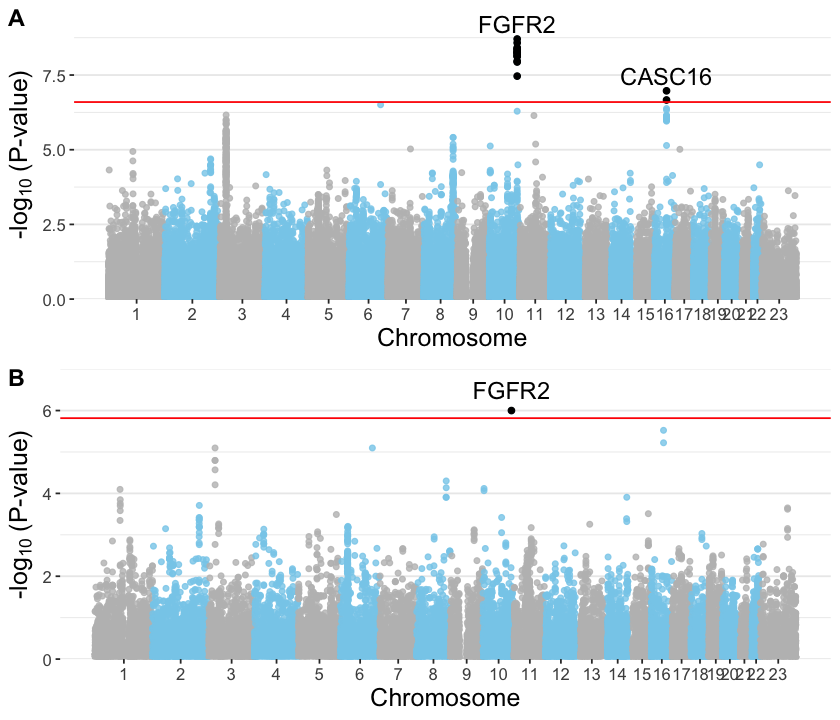

In [4]:
options(repr.plot.width=7, repr.plot.height=6)
f1 <- plot_grid(f1a, f1b, labels = c('A', 'B'), nrow = 2)
f1
ggsave('figures/figure_1.pdf', f1, width=7, height=6)

# Figure 2

In [5]:
dmgwas <- read_tsv(paste0(results,'dmgwas/selected_genes.dmgwas.txt'), col_types = 'c')$gene

options(repr.plot.width=6, repr.plot.height=6)

ppi_dmgwas <- activate(ppi, nodes) %>%
    filter(name %in% dmgwas)
class(ppi_dmgwas) <- 'igraph'

dmgwas_flaw <- ggnetwork(ppi_dmgwas) %>%
    ggplot(aes(x = x, y = y, xend = xend, yend = yend)) +
        geom_edges(color = 'gray80') +
        geom_nodes(aes(color = ifelse(p > 0.1, '> 0.1', '< 0.1'))) +
        labs(color = 'P-value', title = "dmGWAS' solution") +
        theme_blank() +
        scale_color_manual(values = c('> 0.1' = 'gray20', '< 0.1' = 'red')) +
        theme(legend.position = 'bottom',
              plot.title = element_text(hjust = 0.5))

f2 <- plot_grid(dmgwas_flaw, 
          labels = c('A'))

Warning message in fortify.network(intergraph::asNetwork(model), ...):
“duplicated edges detected”

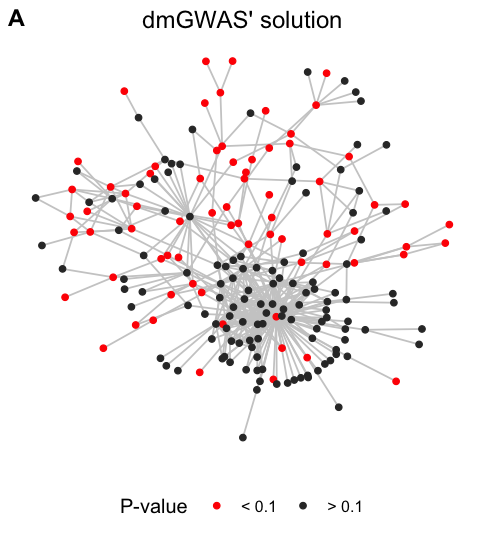

In [6]:
options(repr.plot.width=4, repr.plot.height=4.5)
f2
ggsave('figures/figure_2.pdf', f2, width=4, height=4.5)

# Figure 3

In [7]:
cols_methods <- c('dmGWAS','heinz','SConES GM','SigMod')

set.seed(100)
consensus_nodes <- read_tsv(paste0(results,'consensus/consensus.tsv'), 
                            col_types = 'cdidllllli')

consensus <- inner_join(ppi, consensus_nodes, by = c('name' = 'gene', 'p'))
class(consensus) <- 'igraph'

consensus <- consensus %>%
    ggnetwork %>%
    mutate(vertex.names = as.character(vertex.names))

nodes <- mutate(consensus, dmGWAS = as.numeric(dmgwas),
                heinz = as.numeric(heinz),
                `SConES GM` = as.numeric(scones_gm),
                SigMod = as.numeric(sigmod),
                radius = ifelse(known, 0.03, 0.02)) %>%
    filter(xend == x & yend == y) %>% 
    select(x, y, vertex.names, radius, p, known, cols_methods) %>%
    unique
edges <- filter(consensus, xend != x | yend != y)

f3 <- ggplot() +
    geom_edges(data = edges, aes(x = x, y = y, xend = xend, yend = yend), 
               color = 'grey80', size = 1.2) +
    geom_scatterpie(data = nodes, aes(x = x, y = y, r = radius), cols = cols_methods) +
    geom_text_repel(data = filter(nodes, p < 0.001 | known), 
                    aes(x = x, y = y, label = vertex.names, color = known), 
                    nudge_x = -0.1, nudge_y = -0.05) + 
    coord_fixed() +
    theme_blank() +
    labs(fill = 'Method') +
    scale_color_manual(values = c('TRUE' = '#e96182', 'FALSE' = 'black')) +
    scale_fill_manual(values = method_palette) +
    guides(color = FALSE) +
    theme(legend.position = 'bottom')

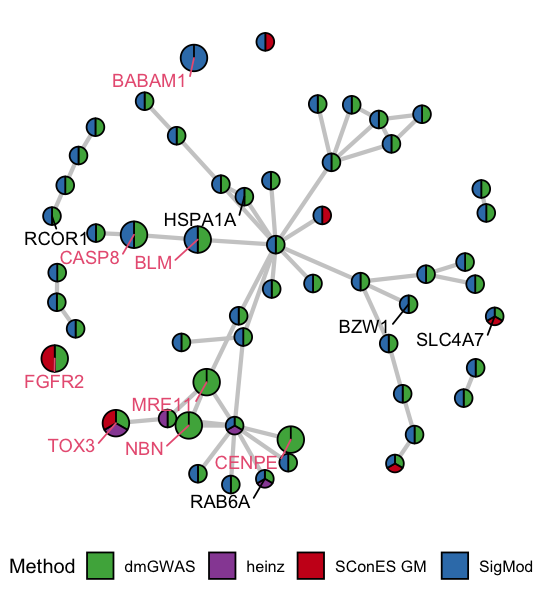

In [8]:
options(repr.plot.width=4.5, repr.plot.height=5)
f3
ggsave('figures/figure_3.pdf', f3, width=4.5, height=5)

# Figure 4: Benchmark

In [9]:
parse_deltatime <- function(column) {
    
    parse_subfield <- function (x) {
        if (grepl('ms', x)) {
            x <- gsub('ms', '', x) %>% as.numeric
            x <- x / 1000
        } else if (grepl('s', x)) {
            x <- gsub('s', '', x) %>% as.numeric
        } else if (grepl('m', x)) {
            x <- gsub('m', '', x) %>% as.numeric
            x <- x * 60
        } else if (grepl('h', x)) {
            x <- gsub('h', '', x) %>% as.numeric
            x <- x * 3600
        } else if (grepl('d', x)) {
            x <- gsub('d', '', x) %>% as.numeric
            x <- x * 3600 * 24
        } else {
            x <- NA
        }
        return(x)   
    }
    
    strsplit(column, ' ') %>% lapply(function(x) lapply(x, parse_subfield) %>% unlist) %>% lapply(sum) %>% unlist  
}

pred_ht <- read_tsv(paste0(results,'benchmark/prediction.tsv'), col_types = 'ciidd') %>%
    mutate(method = ifelse(method == 'dmgwas', 'dmGWAS', method),
           method = ifelse(method == 'scones_gs', 'SConES GS', method),
           method = ifelse(method == 'scones_gm', 'SConES GM', method),
           method = ifelse(method == 'scones_gi', 'SConES GI', method),
           method = ifelse(method == 'sigmod', 'SigMod', method),
           method = ifelse(method == 'all_snps', 'All', method),
           method = factor(method, levels = rev(methods)))

stab_ht <- read_tsv(paste0(results,'benchmark/stability.tsv'), col_types = 'cicd') %>%
    mutate(method = ifelse(method == 'dmgwas', 'dmGWAS', method),
           method = ifelse(method == 'scones_gs', 'SConES GS', method),
           method = ifelse(method == 'scones_gm', 'SConES GM', method),
           method = ifelse(method == 'scones_gi', 'SConES GI', method),
           method = ifelse(method == 'sigmod', 'SigMod', method),
           method = ifelse(method == 'lean', 'LEAN', method),
           method = factor(method, levels = rev(methods)))

In [10]:
sel_act <- pred_ht %>%
    filter(method != 'All') %>%
    group_by(method) %>%
    summarize(se_selected = sd(n_selected) / sqrt(n()),
              se_active = sd(n_active_set) / sqrt(n()),
              n_selected = mean(n_selected),
              n_active_set = mean(n_active_set)) %>%
    ggplot(aes(x = n_selected, y = n_active_set, 
               label = method, color = method)) +
        geom_hline(yintercept = mean(pred_ht$n_active_set[pred_ht$method == 'All']),
                   color = 'gray50') +
        geom_pointrange(aes(ymin = n_active_set - se_active, 
                            ymax = n_active_set + se_active)) +
        geom_errorbarh(aes(xmax = n_selected + se_selected, 
                           xmin = n_selected - se_selected)) +
        geom_text_repel(size = 3) +
        scale_fill_manual(values = method_palette) +
        scale_color_manual(values = method_palette) +
        labs(x = 'Number of selected SNPs', y = 'Active set size', 
             color = 'Method') +
        theme(legend.position = 'none',
              axis.text.x = element_text(size = 9),
              axis.text.y = element_text(size = 9),
              axis.title.x = element_text(size = 11),
              axis.title.y = element_text(size = 11)) + 
        guides(fill = "none")

sens_spec <- pred_ht %>%
    group_by(method) %>%
    summarize(se_sensitivity = sd(sensitivity) / sqrt(n()),
              se_specificity = sd(specificity) / sqrt(n()),
              sensitivity = mean(sensitivity),
              specificity = mean(specificity)) %>%
    ggplot(aes(x = sensitivity, y = specificity, 
               label = method, color = method)) +
        geom_pointrange(aes(ymin = specificity - se_specificity, 
                            ymax = specificity + se_specificity)) +
        geom_errorbarh(aes(xmax = sensitivity + se_sensitivity, 
                           xmin = sensitivity - se_sensitivity)) +
        geom_text_repel(size = 3) +
        scale_y_continuous(limits = c(0.47, 0.62)) +
        scale_x_continuous(limits = c(0.47, 0.62)) +
        scale_fill_manual(values = method_palette) +
        scale_color_manual(values = method_palette) +
        labs(x = 'Sensitivity', y = 'Specificity', color = 'Method') +
        theme(legend.position = 'none',
              axis.text.x = element_text(size = 9),
              axis.text.y = element_text(size = 9),
              axis.title.x = element_text(size = 11),
              axis.title.y = element_text(size = 11)) + 
        guides(fill = "none")

jacc <- ggplot(stab_ht, aes(x = method, y = jaccard, fill = method)) +
    geom_boxplot() +
    coord_flip() +
    labs(y = 'Jaccard') +
    scale_fill_manual(values = method_palette) +
    theme(axis.title.y = element_blank(),
          legend.position = 'none',
          axis.text.x = element_text(size = 9),
          axis.text.y = element_text(size = 9),
          axis.title.x = element_text(size = 11))

time <- read_tsv(paste0(results,'benchmark/trace.txt'), col_types = 'iciccicccccccc') %>%
    separate(name, into = c('method','i'), sep = ' \\(') %>%
    filter(! method %in% c('lasso','make_splits','stability','all_snps',
                           'do_nothing','join_stability','join_analyses','vegas')) %>%
    mutate(method = ifelse(method == 'dmgwas', 'dmGWAS', method),
           method = ifelse(method == 'scones' & grepl('gs', i), 'SConES GS', method),
           method = ifelse(method == 'scones' & grepl('gm', i), 'SConES GM', method),
           method = ifelse(method == 'scones' & grepl('gi', i), 'SConES GI', method),
           method = ifelse(method == 'sigmod', 'SigMod', method),
           method = ifelse(method == 'lean', 'LEAN', method),
           method = factor(method, levels = rev(methods)),
           time_s = parse_deltatime(realtime),
           type = ifelse(grepl('SConES', method), 'SNP', 'Gene')) %>%
    ggplot(aes(x = method, y = time_s, fill = method)) +
        geom_boxplot() +
        scale_fill_manual(values = method_palette) +
        labs(y = 'Time (s)') +
        theme(legend.position = 'none',
              axis.title.y = element_blank(),
              axis.text.x = element_text(size = 9),
              axis.text.y = element_text(size = 9),
              axis.title.x = element_text(size = 11),
              strip.text = element_text(size = 10),
              strip.background = element_rect(fill="gray90")) +
        coord_flip() +
        facet_grid(type ~ ., scales = 'free', space = 'free')

f4 <- plot_grid(sel_act, sens_spec, jacc, time, nrow = 2, labels = c('A','B','C','D'))

Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 2 rows [97, 99].”

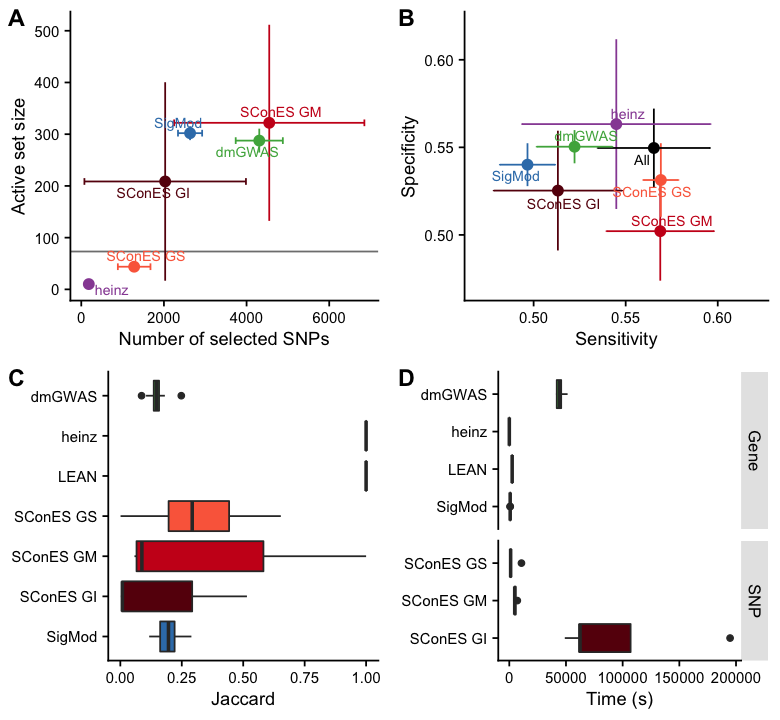

In [11]:
options(repr.plot.width=6.5, repr.plot.height=6)
f4
ggsave('figures/figure_4.pdf', f4, width=6.5, height=6)